# LGD, EAD & Expected Loss 

In [1]:
import numpy as np
import pandas as pd

#libs for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#ML model
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import roc_curve, roc_auc_score

import scipy.stats as stat

#exporting ML model
import pickle

In [2]:
df1 = pd.read_csv("loan_data_inputs_train.csv", index_col = 0)
df2 = pd.read_csv("loan_data_inputs_test.csv", index_col = 0)

In [3]:
loan_data_preprocessed_backup  = pd.concat([df1,df2],axis=0) #'loan_data_2007_2014_preprocessed.csv')
loan_data_preprocessed = loan_data_preprocessed_backup.copy()
df1, df2 = [], [] #deleting the df s that use a large amount of ram source

In [4]:
loan_data_preprocessed.columns.values

array(['Unnamed: 0.1', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       've

In [5]:
loan_data_preprocessed.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
221233,221233,1223440,1464089,16000,16000,16000.0,36 months,17.27,572.60,D,...,0,0,0,1,0,0,0,0,0,0
378461,378461,17654338,19786836,26350,26350,26350.0,60 months,16.99,654.73,D,...,1,0,0,1,0,0,0,0,0,0
117522,117522,6166624,7648747,4800,4800,4800.0,36 months,13.68,163.31,C,...,0,0,0,0,0,0,0,0,0,1
352107,352107,20689629,22962303,14000,14000,14000.0,60 months,15.61,337.56,D,...,0,0,0,1,0,0,0,0,0,0
253931,253931,34743135,37436415,15000,15000,15000.0,36 months,9.49,480.43,B,...,0,0,0,1,0,0,0,0,0,0


In [6]:
# We only need the data on the accounts that were charged-off (written-off).
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed['loan_status'].\
                                            isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])]

In [7]:
loan_data_defaults.shape

(43236, 324)

In [8]:
# Let's fill missing values with zeroes.
loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)

C:\Users\prem kumarr r s\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [9]:
# Let's fill the missing values with zeroes.
loan_data_defaults['mths_since_last_record'].fillna(0, inplace=True)

In [10]:
# For the LGD model, We need to calculate the dependent variable recovery rate.
# It is the ratio of recoveries and funded amount.
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']

C:\Users\prem kumarr r s\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# Let's check out some descriptive statisics for the values of a column.
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

In [12]:
# We have some recovery rate data > 1.0.
# We need to set recovery rates that are greater than 1 to 1 
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
# We need to set recovery rates that are less than 0 to 0. (this part is kept for a future dataset)
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])

C:\Users\prem kumarr r s\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\prem kumarr r s\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [13]:
#let's check if all is good after data cleaning
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

loan_data_defaults['funded_amnt']: The total loan amount disbursed.

loan_data_defaults['total_rec_prncp']: The total principal received back (payments made by the borrower).

Difference: 

(funded_amnt−total_rec_prncp) calculates the outstanding principal at the time of default.

Division: Dividing this outstanding amount by the funded amount gives the proportion (or ratio) of the funded amount that remains unpaid, which is the CCF.

In [14]:
# let's calculate the dependent variable for the EAD model: credit conversion factor.
# It is the ratio of the difference of the amount used at the moment of default to the total funded amount.
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - \
                             loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']

C:\Users\prem kumarr r s\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Amount Used at Default: 

funded_amnt−total_rec_prncp - 

This calculates the remaining amount the borrower has used from the loan (i.e., the portion that hasn't been paid back as principal).

Total Funded Amount: This is the full loan amount the lender originally disbursed.

In [15]:
loan_data_defaults['CCF'].describe()
# Shows some descriptive statisics for the values of a column.

count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

(array([  10.,   21.,   49.,   21.,   51.,   54.,   21.,  103.,   30.,
          93.,   73.,   62.,   96.,   63.,  135.,   99.,  116.,  145.,
         125.,  162.,  140.,  178.,  162.,  178.,  213.,  194.,  228.,
         209.,  258.,  248.,  275.,  263.,  295.,  326.,  372.,  312.,
         409.,  367.,  382.,  420.,  454.,  475.,  528.,  525.,  515.,
         573.,  554.,  655.,  636.,  718.,  742.,  861.,  809.,  965.,
         873., 1105., 1033., 1182., 1130., 1270., 1317., 1360., 1477.,
        1327., 1715., 1457., 1803., 1463., 1874., 1520., 1393., 1568.,
         750.,  999.,  652.]),
 array([4.38000000e-04, 1.37654933e-02, 2.70929867e-02, 4.04204800e-02,
        5.37479733e-02, 6.70754667e-02, 8.04029600e-02, 9.37304533e-02,
        1.07057947e-01, 1.20385440e-01, 1.33712933e-01, 1.47040427e-01,
        1.60367920e-01, 1.73695413e-01, 1.87022907e-01, 2.00350400e-01,
        2.13677893e-01, 2.27005387e-01, 2.40332880e-01, 2.53660373e-01,
        2.66987867e-01, 2.80315360e-01, 2

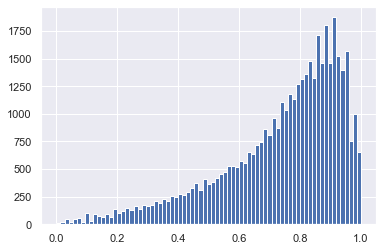

In [16]:
# Plotting a histogram of CCF
plt.hist(loan_data_defaults['CCF'], bins = 75)

Key Observations:

The distribution is heavily skewed toward higher values of CCF (close to 1).
This suggests that, in most cases, borrowers used a significant portion of their loans or credit lines before defaulting.

There are fewer instances with lower CCF values (close to 0).

This indicates it is less common for borrowers to default with minimal usage of their funded amount.

The peak (highest bar) occurs near CCF = 1, showing that many defaults happened with nearly the full amount being utilized.

In [17]:
# Creating a new variable showing 0 for recovery rate being 0 and 1 otherwise.
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)

C:\Users\prem kumarr r s\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
#saving the data in a csv file
loan_data_defaults.to_csv('loan_data_defaults.csv')

# LGD Model

Loss Given Default (LGD) represents the portion of the outstanding amount a lender expects to lose in the event of a borrower's default. It is expressed as a percentage of the total exposure at the time of default or as a dollar value representing the potential loss. LGD is calculated using the formula:

LGD= 1−Recovery Rate

Model Development Process
The LGD model is built in two key steps:

* Step 1 - When the Recovery Rate is Equal to or Greater Than 0

In this scenario, the recovery rate is assessed to ensure it accurately reflects cases where partial or no recovery is expected.

Model Type: Logistic Regression

Reason: Recovery rates that fall between 0 and 1 represent bounded probabilities. Logistic regression is well-suited for this scenario as it predicts outcomes confined to a range of 0 to 1. This ensures the predicted recovery rates remain valid and interpretable as proportions.

* Step 2 - When the Recovery Rate is Equal to or Greater Than 1

Here, the model evaluates scenarios where the recovery rate exceeds the total exposure, accounting for over-recovery situations due to collateral or other mitigating factors.


Model Type: Linear Regression

Reason: In rare cases where the recovery rate exceeds 1 (e.g., over-collateralized loans or situations with penalties and accrued interest), the relationship is no longer bounded. Linear regression is appropriate here because it allows for continuous, unbounded predictions, capturing the potential excess recovery scenarios effectively.

This two-step approach ensures comprehensive modeling of recovery scenarios, enabling accurate estimation of potential losses.

# Step 1 - Logistic

In [19]:
# LGD model step 1 datasets: recovery rate 0 or greater than 0.
# Considering a set of inputs [all cols except recovery rate and CCF] and outputs[recovery_rate_0_1]. Splits the inputs and the targets into four dataframes:
# Inputs - Train n Test, Targets - Train n Test
lgd_X_S1 = loan_data_defaults.drop([ 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1)
lgs_Y_S1 = loan_data_defaults['recovery_rate_0_1']

lgd_X_S1_train, lgd_X_S1_test, lgd_Y_S1_train, lgd_Y_S1_test = train_test_split(lgd_X_S1, lgs_Y_S1, test_size = 0.2, random_state = 42)

In [20]:
# List of all X variables for the models.
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

In [21]:
# List of the dummy X variables, avoiding dummy trick reference categories. 
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

In [22]:
# Here we keep only the variables we need for the model.
lgd_X_S1_train = lgd_X_S1_train[features_all]
# Here we remove the dummy variable reference categories.
lgd_X_S1_train = lgd_X_S1_train.drop(features_reference_cat, axis = 1)

In [23]:
lgd_X_S1_train.isnull().sum()
# Check for missing values. We check whether the value of each row for each column is missing or not,
# then sum accross columns.

grade:A                                0
grade:B                                0
grade:C                                0
grade:D                                0
grade:E                                0
grade:F                                0
home_ownership:MORTGAGE                0
home_ownership:NONE                    0
home_ownership:OTHER                   0
home_ownership:OWN                     0
verification_status:Not Verified       0
verification_status:Source Verified    0
purpose:car                            0
purpose:debt_consolidation             0
purpose:educational                    0
purpose:home_improvement               0
purpose:house                          0
purpose:major_purchase                 0
purpose:medical                        0
purpose:moving                         0
purpose:other                          0
purpose:renewable_energy               0
purpose:small_business                 0
purpose:vacation                       0
purpose:wedding 

In [24]:
# As there is no built-in method to calcualte P values for 
#  sklearn logistic regression

# Build a Class to display p-values for logistic regression in sklearn.

from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)

    def fit(self,X,y):
        self.model.fit(X,y)
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X)
        Cramer_Rao = np.linalg.inv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [25]:
# We create an instance of an object from the 'LogisticRegression' class.
reg_lgd_st_1 = LogisticRegression_with_p_values()

# Estimating the coefficients of the object from the 'LogisticRegression' class
# with X (independent variables) from the first dataframe
# and Y (dependent variables) from the second dataframe.
reg_lgd_st_1.fit(lgd_X_S1_train, lgd_Y_S1_train)

C:\Users\prem kumarr r s\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [26]:
# Stores the names of the columns of a dataframe in a variable.
feature_name = lgd_X_S1_train.columns.values

In [27]:
# Creating a df with a column 'Feature name' and values of the 'feature_name' variable.
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creates a new column called 'Coefficients',
# with row values the transposed coefs from the 'LogisticRegression' object.
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
# Increasing the index of every row of the df with 1.
summary_table.index = summary_table.index + 1
# Assigning values of the row with index 0 of the df.
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
# Sorts the df by index.
summary_table = summary_table.sort_index()
# We take the result of the newly added method 'p_values' and store it in a variable 'p_values'.
p_values = reg_lgd_st_1.p_values
# We add the value 'NaN' in the beginning of the variable with p-values.
p_values = np.append(np.nan,np.array(p_values))
# In the 'summary_table' df, we add a new column, called 'p_values', containing the values from the 'p_values' variable.
summary_table['p_values'] = p_values

summary_table

,Feature name,Coefficients,p_values
0,Intercept,-2.482861e-04,NaN
1,grade:A,-4.410013e-05,9.995890e-01
2,grade:B,-1.516087e-04,9.982609e-01
3,grade:C,-2.402413e-04,9.971489e-01
4,grade:D,8.291388e-06,9.999056e-01
5,grade:E,2.987754e-05,9.996915e-01
6,grade:F,1.318316e-04,9.988180e-01
7,home_ownership:MORTGAGE,-1.140090e-04,9.964284e-01
8,home_ownership:NONE,1.802725e-06,9.999982e-01
9,home_ownership:OTHER,1.716270e-06,9.999968e-01


# Testing the model

In [28]:
# Here we keep only the variables [features_all] that we need for the model.
lgd_X_S1_test = lgd_X_S1_test[features_all]
# Then we remove the dummy variable reference categories.
lgd_X_S1_test = lgd_X_S1_test.drop(features_reference_cat, axis = 1)

In [29]:
# Calculating the predicted vals for the Y (targets) given X (inputs)
y_hat_test_lgd_step_1 = reg_lgd_st_1.model.predict(lgd_X_S1_test)

In [30]:
y_hat_test_lgd_step_1

array([1, 1, 1, ..., 1, 1, 0])

In [31]:
# Calculates the predicted probability for Y (targets) given X (inputs)
y_hat_test_proba_lgd_step_1 = reg_lgd_st_1.model.predict_proba(lgd_X_S1_test)

In [32]:
# arrays of predicted class probabilities
# first val of arrays  is the probability for the observation belonging to the first class, i.e. 0,
# and the second value is the probability for the observation belonging to 1
y_hat_test_proba_lgd_step_1

array([[0.49942832, 0.50057168],
       [0.3159701 , 0.6840299 ],
       [0.48995276, 0.51004724],
       ...,
       [0.29906246, 0.70093754],
       [0.4408537 , 0.5591463 ],
       [0.5623656 , 0.4376344 ]])

In [33]:
# we consider only the probabilities for being 1.
y_hat_test_proba_lgd_step_1 = y_hat_test_proba_lgd_step_1[: ][: , 1]

In [34]:
y_hat_test_proba_lgd_step_1

array([0.50057168, 0.6840299 , 0.51004724, ..., 0.70093754, 0.5591463 ,
       0.4376344 ])

In [35]:
lgd_Y_S1_test_temp = lgd_Y_S1_test

In [36]:
# resetting the index of a dataframe.
lgd_Y_S1_test_temp.reset_index(drop = True, inplace = True)

In [37]:
# Concatenating two dataframes.
df_actual_predicted_probs = pd.concat([lgd_Y_S1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_step_1)], axis = 1)

In [38]:
df_actual_predicted_probs.columns = ['lgd_targets_step_1_test', 'y_hat_test_proba_lgd_step_1']

In [39]:
# Making the indices eqv to each other
df_actual_predicted_probs.index = lgd_X_S1_test.index

In [40]:
df_actual_predicted_probs.head()

,lgd_targets_step_1_test,y_hat_test_proba_lgd_step_1
387009,1,0.500572
192476,0,0.684030
54932,0,0.510047
225852,1,0.719512
54403,0,0.498202


# Estimating the accuracy of the model

In [41]:
tr = 0.5
# Indicator column created to give '1' for the cases where predicted proba is greater than threshold
df_actual_predicted_probs['y_hat_test_lgd_step_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_step_1'] > tr, 1, 0)

In [42]:
# Creating a cross-table, a Confusion Matrix where the actual vals are displayed by rows and the predicted vals by columns.
pd.crosstab(df_actual_predicted_probs['lgd_targets_step_1_test'], df_actual_predicted_probs['y_hat_test_lgd_step_1'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,1337,2471
1,892,3948


In [43]:
# Gettign rates by dividing values by the tot number of observations,
cmatrix_p = pd.crosstab(df_actual_predicted_probs['lgd_targets_step_1_test'], \
                        df_actual_predicted_probs['y_hat_test_lgd_step_1'], \
                        rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]
cmatrix_p

Predicted,0,1
Actual,,
0,0.154602,0.285731
1,0.103145,0.456522


15.46% of the total observations were True Negatives (TN). - non default

45.65% of the total observations were True Positives (TP). - default

In [44]:
# Calculating accuracy of the model = sum of the diagonal rates.
cmatrix_p.iloc[0, 0] + cmatrix_p.iloc[1, 1]

0.6111239592969473

The model's overall accuracy is 61.1%, which means it correctly predicted the outcomes (default or no default) for 61.1% of the observations. (15.46 + 45.65)

In [45]:
# Getting Receiver Operating Characteristic (ROC) Curve: the false positive rates, the true positive rates, and the thresholds.
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_step_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_step_1'])

Text(0.5, 1.0, 'ROC curve')

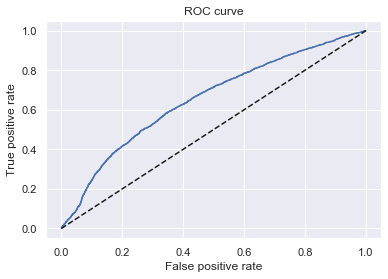

In [46]:
# We plot the ROC: false positive rate along the x-axis and the true positive rate along the y-axis,
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [47]:
# Calculating the Area Under the Receiver Operating Characteristic Curve (AUROC)
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_step_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_step_1'])
AUROC

0.6532737733523162

0.653 indicates that the model has moderate discriminatory power. It performs better than random guessing but leaves room for improvement.

# Saving the Model

In [48]:
# Exporting our model to a 'SAV' file
pickle.dump(reg_lgd_st_1, open('lgd_model_step_1.sav', 'wb'))

# Step 2 - Linear

In [49]:
# Here we take only rows where the original recovery rate variable is greater than one,
# i.e. where the indicator variable we created is equal to 1.
lgd_step_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]

In [50]:
# LGD model stage 2 datasets: how much more than 0 is the recovery rate
lgd_X_S2 = lgd_step_2_data.drop([ 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1)
lgd_Y_S2 = lgd_step_2_data['recovery_rate']
# splitting Inputs - Train + Test and  Targets - Train + Test.
lgd_X_S2_train, lgd_X_S2_test, lgd_Y_S2_train, lgd_Y_S2_test = train_test_split(lgd_X_S2, lgd_Y_S2, test_size = 0.2, random_state = 42)
# freeing the memory used by following arrays
lgd_x_S2, lgd_Y_S2  = [],[]

In [51]:
# keeping the variables needed for the model.
lgd_X_S2_train = lgd_X_S2_train[features_all]
# removing the dummy variable reference categories.
lgd_X_S2_train = lgd_X_S2_train.drop(features_reference_cat, axis = 1)

In [52]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [53]:
# Since the p-values are obtained through certain statistics, we need the 'stat' module from scipy.stats
import scipy.stats as stat

# Since we are using an object oriented language such as Python, we can simply define our own 
# LinearRegression class (the same one from sklearn)
# By typing the code below we will ovewrite a part of the class with one that includes p-values
# Here's the full source code of the ORIGINAL class: https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/linear_model/base.py#L362


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs

    
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        
        # Calculate SSE (sum of squared errors)
        # and SE (standard error)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        # compute the t-statistic for each feature
        self.t = self.coef_ / se
        # find the p-value for each feature
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [54]:
import scipy.stats as stat

class LinearRegression(linear_model.LinearRegression):
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
        self.t = self.coef_ / se
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [55]:
# creating an instance of an object from the 'LogisticRegression' class.
reg_lgd_st_2 = LinearRegression()
# Estimating the coeffs w X_train and Y_train
reg_lgd_st_2.fit(lgd_X_S2_train, lgd_Y_S2_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [56]:
# Storing the names of the columns
feature_name = lgd_X_S2_train.columns.values

In [57]:
# Creating a df with a column 'Feature name' and vals in 'feature_name'
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creating a new column 'Coefficients' w row values the transposed coefficients from the 'LogisticRegression' object.
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
# Increasing the index of every row of the dataframe with 1.
summary_table.index = summary_table.index + 1
# Assigning values of the row with index 0 of the dataframe.
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
# Sorting the dataframe by index.
summary_table = summary_table.sort_index()
# Taking the result of the newly added method 'p_values' and store it in a variable 'p_values'.
p_values = reg_lgd_st_2.p
# Adding the value 'NaN' in the beginning of the variable with p-values.
p_values = np.append(np.nan,np.array(p_values))
# Adding a column of 'p_values', containing the values
summary_table['p_values'] = p_values.round(3)

summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.671710e-01,NaN
1,grade:A,-7.941294e-02,0.000
2,grade:B,-6.141295e-02,0.000
3,grade:C,-4.601369e-02,0.000
4,grade:D,-3.339446e-02,0.000
5,grade:E,-1.883676e-02,0.000
6,grade:F,-4.824449e-03,0.313
7,home_ownership:MORTGAGE,2.788802e-03,0.060
8,home_ownership:NONE,1.581668e-01,0.000
9,home_ownership:OTHER,5.013524e-02,0.009


# Model Evaluation

In [58]:
# keeping the variables needed
lgd_X_S2_test = lgd_X_S2_test[features_all]

In [59]:
# Removing the dummy variable reference categories.
lgd_X_S2_test = lgd_X_S2_test.drop(features_reference_cat, axis = 1)

In [60]:
# Calculating the predicted vals for Y given X
lgd_X_S2_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [61]:
# Predicting Y given X
y_hat_test_lgd_step_2 = reg_lgd_st_2.predict(lgd_X_S2_test)

In [62]:
lgd_Y_S2_test_temp = lgd_Y_S2_test

In [63]:
# Resetting the index of a dataframe.
lgd_Y_S2_test_temp = lgd_Y_S2_test_temp.reset_index(drop = True)

In [64]:
# Calculating the correlation between actual and predicted values.
pd.concat([lgd_Y_S2_test_temp, pd.DataFrame(y_hat_test_lgd_step_2)], axis = 1).corr()

,recovery_rate,0
recovery_rate,1.000000,0.285338
0,0.285338,1.000000


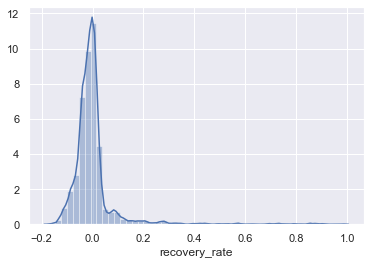

In [65]:

# Plotting the distribution of the residuals.
sns.distplot(lgd_Y_S2_test_temp - y_hat_test_lgd_step_2)

In [66]:
# Here we export our model
pickle.dump(reg_lgd_st_2, open('lgd_model_step_2.sav', 'wb'))

# Combining Steps 1 & 2

In [67]:
y_hat_test_lgd_step_2_all = reg_lgd_st_2.predict(lgd_X_S1_test)

In [68]:
y_hat_test_lgd_step_2_all

array([0.14490989, 0.09378632, 0.16806972, ..., 0.11066644, 0.12061587,
       0.16370634])

In [69]:
# combining the predictions of the models from the two steps.y_hat_test_proba_lgd_step_1
y_hat_test_lgd = y_hat_test_lgd_step_1 * y_hat_test_lgd_step_2_all 

In [70]:
# Showing descriptive stats 
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.078545
std,0.052018
min,-0.005605
25%,0.000000
50%,0.095716
75%,0.118393
max,0.244173


In [71]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)
# We set predicted values that are greater than 1 to 1 and predicted values that are less than 0 to 0.

In [72]:
pd.DataFrame(y_hat_test_lgd).describe()
# Shows some descriptive statisics for the values of a column.

,0
count,8648.000000
mean,0.078546
std,0.052016
min,0.000000
25%,0.000000
50%,0.095716
75%,0.118393
max,0.244173


# EAD Model

Exposure at Default (EAD):

EAD is the total value of the lender’s exposure to a borrower at the time of default. This includes outstanding balances and potential future draws on credit lines.

# Linear Modelling

In [73]:
# EAD model datasets
# Splitting into Inputs - Train n Test, Targets - Train n Test.
ead_X = loan_data_defaults.drop([ 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1)
ead_Y = loan_data_defaults['CCF']
ead_X_train, ead_X_test, ead_Y_train, ead_Y_test = train_test_split(ead_X, ead_Y, test_size = 0.2, random_state = 42)
ead_X, ead_Y = [],[]

In [74]:
ead_X_train.columns.values

array(['Unnamed: 0.1', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       've

In [75]:
# Keeping only the variables we need n removing the dummy var. reference categories.
ead_X_train = ead_X_train[features_all]
ead_X_train = ead_X_train.drop(features_reference_cat, axis = 1)

In [76]:
# Creating an instance of an object from the 'LogisticRegression' class.
reg_ead = LinearRegression()
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.
reg_ead.fit(ead_X_train, ead_Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [77]:
feature_name = ead_X_train.columns.values

In [78]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_ead.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.128547e+00,NaN
1,grade:A,-3.095957e-01,0.000000e+00
2,grade:B,-2.400282e-01,0.000000e+00
3,grade:C,-1.754033e-01,0.000000e+00
4,grade:D,-1.217642e-01,0.000000e+00
5,grade:E,-6.866023e-02,0.000000e+00
6,grade:F,-2.239783e-02,2.116834e-03
7,home_ownership:MORTGAGE,-7.097627e-03,7.455994e-04
8,home_ownership:NONE,5.653760e-02,3.835892e-01
9,home_ownership:OTHER,6.163743e-03,8.396019e-01


# Model Validation

In [79]:
# keeping only the variables needed and removing dummy variables
ead_X_test = ead_X_test[features_all]
ead_X_test = ead_X_test.drop(features_reference_cat, axis = 1)

In [80]:
ead_X_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [81]:
# Calculating the predicted vals
y_hat_test_ead = reg_ead.predict(ead_X_test)

In [82]:
ead_Y_test_temp = ead_Y_test

In [83]:
ead_Y_test_temp = ead_Y_test_temp.reset_index(drop = True)
# We reset the index of a dataframe.

In [84]:
# Calculating the correlation between actual and predicted values.
pd.concat([ead_Y_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()

,CCF,0
CCF,1.000000,0.521143
0,0.521143,1.000000


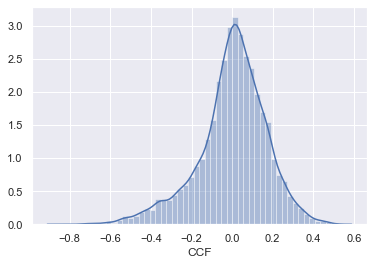

In [85]:
# Plotting the distribution of the residuals.
sns.distplot(ead_Y_test - y_hat_test_ead)

In [86]:
# Descriptive statisics for the values of a column.
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.737175
std,0.104685
min,0.371711
25%,0.664153
50%,0.733357
75%,0.811925
max,1.046097


In [87]:
# Setting predicted values that are greater than 1 to 1 and vice versa
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)

In [88]:
# some descriptive statisics for the values of a column.
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.737168
std,0.104667
min,0.371711
25%,0.664153
50%,0.733357
75%,0.811925
max,1.000000


# Expected Loss calculation

In [89]:
#cleaning the memory
loan_data_preprocessed_backup = []

loan_data_defaults = []
lgd_X_S1_train, lgd_X_S1_test, lgd_Y_S1_train, lgd_Y_S1_test  = [], [],[],[]
lgd_step_2_data =[]
lgd_X_S2_train, lgd_X_S2_test, lgd_Y_S2_train, lgd_Y_S2_test = [],[],[],[]
ead_X_train, ead_X_test, ead_Y_train, ead_Y_test = [], [], [], []

In [90]:

# filling the missing values with zeroes.
loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)
loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)

In [91]:

# keeping the variables only we need for the model.
loan_data_preprocessed_lgd_ead = loan_data_preprocessed[features_all]
# removing the dummy variable ref cats.
loan_data_preprocessed_lgd_ead = loan_data_preprocessed_lgd_ead.drop(features_reference_cat, axis = 1)

## LGD

In [92]:
### 1- LGD MODELS ###
# using step 1 LGD model to calculate predicted values.
loan_data_preprocessed['recovery_rate_st_1'] = reg_lgd_st_1.model.predict(loan_data_preprocessed_lgd_ead)
# using step 2 LGD model to calculate predicted values.
loan_data_preprocessed['recovery_rate_st_2'] = reg_lgd_st_2.predict(loan_data_preprocessed_lgd_ead)

In [93]:
# Combining the predicted values from steps 1 + 2 to determine the final estimated recovery rate.
loan_data_preprocessed['recovery_rate'] = loan_data_preprocessed['recovery_rate_st_1'] * loan_data_preprocessed['recovery_rate_st_2']
# Setting estimated recovery rates greater than 1 to 1 and vice versa
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] < 0, 0, loan_data_preprocessed['recovery_rate'])
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] > 1, 1, loan_data_preprocessed['recovery_rate'])

In [94]:
# Calculating estimated LGD. Estimated LGD equals 1 - estimated recovery rate.
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']
# Some descriptive statisics
loan_data_preprocessed['LGD'].describe()

count    466285.000000
mean          0.930099
std           0.058060
min           0.321240
25%           0.879388
50%           0.910758
75%           1.000000
max           1.000000
Name: LGD, dtype: float64

## EAD MODEL

In [95]:
# Applying EAD model to calculate estimated credit conversion factor.
loan_data_preprocessed['CCF'] = reg_ead.predict(loan_data_preprocessed_lgd_ead)

In [96]:
# Setting estimated CCF that are greater than 1 to 1 and vice versa
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] < 0, 0, loan_data_preprocessed['CCF'])
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] > 1, 1, loan_data_preprocessed['CCF'])

In [97]:
# Estimated EAD = estimated CCF multiplied by funded amount.
loan_data_preprocessed['EAD'] = loan_data_preprocessed['CCF'] * loan_data_preprocessed_lgd_ead['funded_amnt']
# Some descriptive statisics
loan_data_preprocessed['EAD'].describe()

count    466285.000000
mean      10800.810655
std        6922.985993
min         185.951812
25%        5492.948057
50%        9201.218979
75%       14667.034476
max       35000.000000
Name: EAD, dtype: float64

## PD MODEL 

In [98]:
# Importing data to apply the PD model.
loan_data_inputs_train = pd.read_csv('loan_data_inputs_train.csv')
loan_data_inputs_test = pd.read_csv('loan_data_inputs_test.csv')

In [99]:
# Concating the two dfs
loan_data_inputs_pd = pd.concat([loan_data_inputs_train, loan_data_inputs_test], axis = 0)
# #clearing memeory
loan_data_inputs_train, loan_data_inputs_test = [],[] 

In [100]:
loan_data_inputs_pd.shape

(466285, 325)

In [101]:
loan_data_inputs_pd.head()

,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
0,221233,221233,1223440,1464089,16000,16000,16000.0,36 months,17.27,572.60,...,0,0,0,1,0,0,0,0,0,0
1,378461,378461,17654338,19786836,26350,26350,26350.0,60 months,16.99,654.73,...,1,0,0,1,0,0,0,0,0,0
2,117522,117522,6166624,7648747,4800,4800,4800.0,36 months,13.68,163.31,...,0,0,0,0,0,0,0,0,0,1
3,352107,352107,20689629,22962303,14000,14000,14000.0,60 months,15.61,337.56,...,0,0,0,1,0,0,0,0,0,0
4,253931,253931,34743135,37436415,15000,15000,15000.0,36 months,9.49,480.43,...,0,0,0,1,0,0,0,0,0,0


In [102]:
# Setting the index 
loan_data_inputs_pd = loan_data_inputs_pd.set_index('Unnamed: 0')
loan_data_inputs_pd.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
221233,221233,1223440,1464089,16000,16000,16000.0,36 months,17.27,572.60,D,...,0,0,0,1,0,0,0,0,0,0
378461,378461,17654338,19786836,26350,26350,26350.0,60 months,16.99,654.73,D,...,1,0,0,1,0,0,0,0,0,0
117522,117522,6166624,7648747,4800,4800,4800.0,36 months,13.68,163.31,C,...,0,0,0,0,0,0,0,0,0,1
352107,352107,20689629,22962303,14000,14000,14000.0,60 months,15.61,337.56,D,...,0,0,0,1,0,0,0,0,0,0
253931,253931,34743135,37436415,15000,15000,15000.0,36 months,9.49,480.43,B,...,0,0,0,1,0,0,0,0,0,0


In [103]:
features_all_pd = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
#'addr_state:NM_VA',
#'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
#'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',                
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
#'mths_since_earliest_cr_line:141-164',
#'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
#'delinq_2yrs:0',
#'delinq_2yrs:1-3',
#'delinq_2yrs:>=4',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'open_acc:0',
#'open_acc:1-3',
#'open_acc:4-12',
#'open_acc:13-17',
#'open_acc:18-22',
#'open_acc:23-25',
#'open_acc:26-30',
#'open_acc:>=31',
#'pub_rec:0-2',
#'pub_rec:3-4',
#'pub_rec:>=5',
'total_acc:<=27',
'total_acc:28-51',
#'total_acc:>=52',
#'acc_now_delinq:0',
#'acc_now_delinq:>=1',
#'total_rev_hi_lim:<=5K',
#'total_rev_hi_lim:5K-10K',
#'total_rev_hi_lim:10K-20K',
#'total_rev_hi_lim:20K-30K',
#'total_rev_hi_lim:30K-40K',
#'total_rev_hi_lim:40K-55K',
#'total_rev_hi_lim:55K-95K',
#'total_rev_hi_lim:>95K',
#'annual_inc:<20K',
#'annual_inc:20K-30K',
#'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
#'mths_since_last_delinq:Missing',
#'mths_since_last_delinq:0-3',
#'mths_since_last_delinq:4-30',
#'mths_since_last_delinq:31-56',
#'mths_since_last_delinq:>=57',
#'mths_since_last_record:Missing',
#'mths_since_last_record:0-2',
#'mths_since_last_record:3-20',
#'mths_since_last_record:21-31',
#'mths_since_last_record:32-80',
#'mths_since_last_record:81-86',
#'mths_since_last_record:>=86',
]

In [104]:
ref_categories_pd = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',                  
'int_rate:>20.281',
#'mths_since_earliest_cr_line:<140',
#'delinq_2yrs:>=4',
'inq_last_6mths:>6',
#'open_acc:0',
#'pub_rec:0-2',
'total_acc:<=27',
#'acc_now_delinq:0',
#'total_rev_hi_lim:<=5K',
#'annual_inc:<20K',
'dti:>35',
#'mths_since_last_delinq:0-3',
#'mths_since_last_record:0-2'
]

In [105]:
# keeping the variables that we need for the PD model.
loan_data_inputs_pd_temp = loan_data_inputs_pd[features_all_pd]
# removing the dummy variable reference categories.
loan_data_inputs_pd_temp = loan_data_inputs_pd_temp.drop(ref_categories_pd, axis = 1)

In [106]:
loan_data_inputs_pd_temp.shape

(466285, 69)

In [107]:
# Importing the PD model, stored in second notebook
reg_pd = pickle.load(open('pd_model.sav', 'rb'))
# applying the PD model -  estimated default probabilities
loan_data_inputs_pd['PD'] = reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]
# Some descriptive stats
loan_data_inputs_pd['PD'].describe()

count    466285.000000
mean          0.107513
std           0.068289
min           0.006871
25%           0.055990
50%           0.092687
75%           0.144240
max           0.521487
Name: PD, dtype: float64

In [108]:
# List of columns we want to convert
required_columns = ['funded_amnt', 'PD', 'LGD', 'EAD']

# Convert columns in loan_data_preprocessed if they exist
for col in required_columns:
    if col in loan_data_preprocessed.columns:
        loan_data_preprocessed[col] = loan_data_preprocessed[col].astype('float32')

# Convert columns in loan_data_inputs_pd if they exist
for col in required_columns:
    if col in loan_data_inputs_pd.columns:
        loan_data_inputs_pd[col] = loan_data_inputs_pd[col].astype('float32')

In [109]:
print("Data types in loan_data_preprocessed:\n", loan_data_preprocessed.dtypes)
print("Data types in loan_data_inputs_pd:\n", loan_data_inputs_pd.dtypes)

Data types in loan_data_preprocessed:
 Unnamed: 0.1            int64
id                      int64
member_id               int64
loan_amnt               int64
funded_amnt           float32
                       ...   
recovery_rate_st_2    float64
recovery_rate         float64
LGD                   float32
CCF                   float64
EAD                   float32
Length: 330, dtype: object
Data types in loan_data_inputs_pd:
 Unnamed: 0.1                      int64
id                                int64
member_id                         int64
loan_amnt                         int64
funded_amnt                     float32
                                 ...   
mths_since_last_record:21-31      int64
mths_since_last_record:32-80      int64
mths_since_last_record:81-86      int64
mths_since_last_record:>86        int64
PD                              float32
Length: 325, dtype: object


In [110]:
# Concate PD with LGD and EAD
loan_data_preprocessed_new = pd.concat([loan_data_preprocessed, loan_data_inputs_pd], axis = 1)
loan_data_preprocessed_new.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86,PD
221233,221233,1223440,1464089,16000,16000.0,16000.0,36 months,17.27,572.60,D,...,0,0,1,0,0,0,0,0,0,0.228009
378461,378461,17654338,19786836,26350,26350.0,26350.0,60 months,16.99,654.73,D,...,0,0,1,0,0,0,0,0,0,0.135308
117522,117522,6166624,7648747,4800,4800.0,4800.0,36 months,13.68,163.31,C,...,0,0,0,0,0,0,0,0,1,0.082443
352107,352107,20689629,22962303,14000,14000.0,14000.0,60 months,15.61,337.56,D,...,0,0,1,0,0,0,0,0,0,0.092718
253931,253931,34743135,37436415,15000,15000.0,15000.0,36 months,9.49,480.43,B,...,0,0,1,0,0,0,0,0,0,0.023058


In [111]:
# Keeping necessary colomns for memory
loan_data_preprocessed_new = loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD']] 

In [112]:
# Cleaning memory
loan_data_preprocessed, loan_data_inputs_pd = [],[]

In [113]:
loan_data_preprocessed_new.shape

(466285, 5)

## Expected Loss (EL):
EL quantifies the potential loss from a loan portfolio by incorporating the probability of default, the exposure at default, and the loss given default.

Formula:

EL=PD×EAD×LGD

In [114]:
# Calculating Expected Loss. EL = PD * LGD * EAD.
loan_data_preprocessed_new['EL'] = loan_data_preprocessed_new['PD'] * loan_data_preprocessed_new['LGD'] * loan_data_preprocessed_new['EAD']
# Some descriptive statisics for the values of a column.
loan_data_preprocessed_new['EL'].describe()

count    466285.000000
mean       1079.662964
std        1092.823853
min           2.680662
25%         353.664795
50%         703.186584
75%        1404.447021
max       11366.155273
Name: EL, dtype: float64

In [115]:
loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD', 'EL']].head()

,funded_amnt,funded_amnt,PD,LGD,EAD,EL
221233,16000.0,16000.0,0.228009,0.922675,10261.286133,2158.747070
378461,26350.0,26350.0,0.135308,1.000000,23229.871094,3143.178711
117522,4800.0,4800.0,0.082443,0.870888,3337.571777,239.633362
352107,14000.0,14000.0,0.092718,1.000000,12810.712891,1187.777344
253931,15000.0,15000.0,0.023058,0.848737,11528.258789,225.607407


In [116]:
loan_data_preprocessed_new['funded_amnt'].describe()

,funded_amnt,funded_amnt
count,466285.000000,466285.000000
mean,14295.994141,14295.994141
std,8277.877930,8277.877930
min,500.000000,500.000000
25%,8000.000000,8000.000000
50%,12000.000000,12000.000000
75%,20000.000000,20000.000000
max,35000.000000,35000.000000


In [117]:
# Total Expected Loss for All Loans calculated below
loan_data_preprocessed_new['EL'].sum()

503435200.0

In [118]:
# Total funded amount for all loans calculated below
loan_data_preprocessed_new['funded_amnt'].sum()[0]

6666007600.0

In [119]:
# Total expected loss divided by total funded amount for all loans.
loan_data_preprocessed_new['EL'].sum() / loan_data_preprocessed_new['funded_amnt'].sum()

funded_amnt    0.075523
funded_amnt    0.075523
dtype: float32

In [120]:
#Total expected loss divided by total funded amount for all loans is equal to 7.55%. 
#It is the percentage that the credit institute needs to take into consideration
#in its future decisions on credit loan requirements.